# Medical image analysis with PyTorch

Create a deep convolutional network for an image translation task with PyTorch from scratch and train it on a subset of the IXI dataset for a T1-w to T2-w transformation.

### Setup notebook

In [0]:
from typing import Callable, List, Optional, Tuple, Union

from glob import glob
import os
import random
import sys

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision
from torchvision.transforms import Compose

 Support in-notebook plotting

In [0]:
%matplotlib inline

Report versions

In [0]:
print('numpy version: {}'.format(np.__version__))
from matplotlib import __version__ as mplver
print('matplotlib version: {}'.format(mplver))
print(f'pytorch version: {torch.__version__}')
print(f'torchvision version: {torchvision.__version__}')

numpy version: 1.17.2
matplotlib version: 3.1.1
pytorch version: 1.3.0
torchvision version: 0.4.1a0+d94043a


In [0]:
pv = sys.version_info
print('python version: {}.{}.{}'.format(pv.major, pv.minor, pv.micro))

python version: 3.7.5


Reload packages where content for package development

In [0]:
%load_ext autoreload
%autoreload 2

Check GPU(s)

In [0]:
!nvidia-smi

Mon Dec  9 13:16:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 430.40       Driver Version: 430.40       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla M40 24GB      Off  | 00000000:02:00.0 Off |                    0 |
| N/A   32C    P8    16W / 250W |      0MiB / 22945MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla M40 24GB      Off  | 00000000:03:00.0 Off |                    0 |
| N/A   56C    P0   112W / 250W |   1217MiB / 22945MiB |     76%      Default |
+-------------------------------+----------------------+----------------------+
        

Set seeds for reproducibility

In [0]:
seed = 1
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

## Step 1: Training and validation data setup

Get the location of the training (and validation) data

In [0]:
train_dir = 'set this to full path to training data'
t1_dir = os.path.join(train_dir, 't1')
t2_dir = os.path.join(train_dir, 't2')

In [0]:
t1_fns = glob(os.path.join(t1_dir, '*.nii*'))
t2_fns = glob(os.path.join(t2_dir, '*.nii*'))
assert len(t1_fns) == len(t2_fns) and len(t1_fns) != 0

### Milestone 1

Look at an axial view of the source T1-weighted (T1-w) and target T2-weighted (T2-w) images.

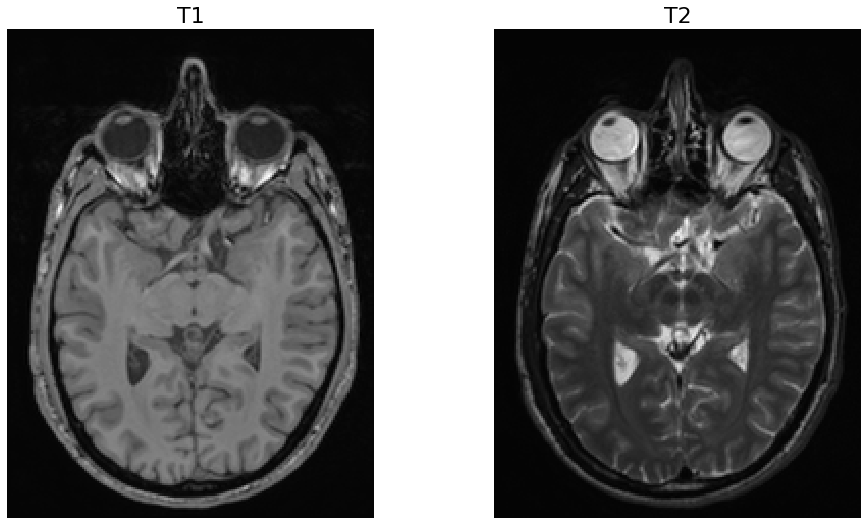

In [0]:
t1_ex, t2_ex = nib.load(t1_fns[0]).get_data(), nib.load(t2_fns[0]).get_data()
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,9))
ax1.imshow(t1_ex[:,135,:], cmap='gray'); ax1.set_title('T1',fontsize=22); ax1.axis('off'); 
ax2.imshow(t2_ex[:,135,:], cmap='gray'); ax2.set_title('T2',fontsize=22); ax2.axis('off'); 